In [1]:
import torch
from torch.nn import Sequential, Linear, ReLU, Sigmoid, Tanh, Dropout, Upsample
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GENConv, GATv2Conv
import numpy as np
from torch_geometric.data import Data
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch_geometric.utils import dense_to_sparse
import torch_geometric.utils

from torch.distributions import normal, kl

from tqdm import tqdm

from sklearn.model_selection import KFold
import pandas as pd
from MatrixVectorizer import MatrixVectorizer


In [2]:
# set global variables
N_SUBJECTS = 167

N_LR_NODES = 160

N_HR_NODES = 268

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

N_LR_NODES_F = int(N_LR_NODES * (N_LR_NODES-1) / 2)
N_HR_NODES_F = int(N_HR_NODES * (N_HR_NODES-1) / 2)

In [3]:
from data_preparation import load_data_tensor

lr_train, lr_test, hr_train = load_data_tensor("dgl-icl")

lr_X_dim1 = torch.load('model_autoencoder/final_embeddings/encode_lr.pt')
lr_X_dim3 = torch.load('model_autoencoder/final_embeddings/encode_lr_3.pt')
hr_X_dim1 = torch.load('model_autoencoder/final_embeddings/encode_hr.pt')
hr_X_dim3 = torch.load('model_autoencoder/final_embeddings/encode_hr_3.pt')
lr_X_dim1_test = torch.load('model_autoencoder/final_embeddings/encode_lr_test.pt')
hr_X_dim3_test = torch.load('model_autoencoder/final_embeddings/encode_lr_test_3.pt')

# Model Layers

In [4]:
def generate_steps(num_steps, low=N_LR_NODES, high=N_HR_NODES):
    step_size = (high - low) / (num_steps - 1)
    steps_list = [round(low + step_size * i) for i in range(num_steps)]
    return steps_list

In [39]:
from torch import nn
import torch
import torch.nn.functional as F


class AdjacencyStep(nn.Module):
    def __init__(self, old_dim, new_dim, channels, dt=1., alpha=0.3, gamma=0.3, dropout=0.1):
        super().__init__()
        self.dt = dt
        self.alpha = alpha
        self.gamma = gamma
        # self.gnn = GENConv(channels, channels, aggr='powermean', learn_p=True)
        self.gnn = GATv2Conv(channels, channels, edge_dim=1).to(DEVICE)
        self.dropout = dropout
        # self.dim_changer1 = nn.Parameter(torch.randn((new_dim, 1), device=DEVICE))
        # self.dim_changer2 = nn.Parameter(torch.randn((1, old_dim), device=DEVICE))
        self.dim_changer = nn.Parameter(torch.randn((new_dim, old_dim), device=DEVICE))
        self.A_dim_changer = nn.Parameter(torch.randn((new_dim, old_dim), device=DEVICE))
        # self.A_dim_changer1 = nn.Parameter(torch.randn((new_dim, 1), device=DEVICE))   
        # self.A_dim_changer2 = nn.Parameter(torch.randn((1, old_dim), device=DEVICE))
        self.Z_dim_changer = nn.Parameter(torch.randn((channels, new_dim), device=DEVICE))

        # self.Z_dim_changer1 = nn.Parameter(torch.randn((channels, 1), device=DEVICE))   
        # self.Z_dim_changer2 = nn.Parameter(torch.randn((1, new_dim), device=DEVICE))

        self.forget_gate = nn.Parameter(torch.randn(new_dim, device=DEVICE))
        self.input_gate = nn.Parameter(torch.randn(new_dim, device=DEVICE))

        self.batchnorm_A = torch_geometric.nn.norm.BatchNorm(new_dim)
        self.layernorm_forget_A = torch_geometric.nn.norm.LayerNorm((new_dim, new_dim))
        self.layernorm_input_Z = torch_geometric.nn.norm.LayerNorm((new_dim, new_dim))
        self.batchnorm_X = torch_geometric.nn.norm.BatchNorm(new_dim)
        self.batchnorm_Y = torch_geometric.nn.norm.BatchNorm(new_dim)



    def forward(self, X, Y, A):
        # solve ODEs using simple IMEX scheme
        # dim_changer = self.dim_changer1 @ self.dim_changer2 
        # A_dim_changer = self.A_dim_changer1 @ self.A_dim_changer2
        # Z_dim_changer = self.Z_dim_changer1 @ self.Z_dim_changer2
        dim_changer = self.dim_changer
        A_dim_changer = self.A_dim_changer
        Z_dim_changer = self.Z_dim_changer

        # forget gate from previous adjacency
        f = F.sigmoid(self.forget_gate)
        i = F.sigmoid(self.input_gate)
        forget_A = F.elu(A_dim_changer @ A @ A_dim_changer.T)
        forget_A = f[:, None] * self.layernorm_forget_A(forget_A)
        torch.cuda.empty_cache()

    
        # update node features with gcn
        # edge_index, edge_weights = dense_to_sparse(A)
        data_list = []
        for x, adj in zip(X, A):
            edge_index = adj.nonzero().t()
            edge_weights = adj[edge_index[0], edge_index[1]]
            data = Data(x=x, edge_index=edge_index, edge_attr=edge_weights.view(-1, 1))
            data_list.append(data)
        graph_batch = torch_geometric.data.Batch().from_data_list(data_list)
        Z = self.gnn(graph_batch.x, graph_batch.edge_index, graph_batch.edge_attr).reshape(X.shape)
        torch.cuda.empty_cache()
        input_Z = F.elu(dim_changer @ Z @ Z_dim_changer)
        input_Z = i[:, None] * self.layernorm_input_Z(input_Z)
        torch.cuda.empty_cache()



        # get new adjacency matrix
        new_A = forget_A + input_Z
        new_A = self.batchnorm_A(new_A)
        new_A = (new_A + torch.transpose(new_A, -1, -2)) / 2
        new_A = F.tanh(F.relu(new_A))

        torch.cuda.empty_cache()
        # new_A = new_A + torch.diag_embed(torch.diagonal(new_A, 0)).to(DEVICE) - torch.eye(new_A.shape[0]).to(DEVICE)  # remove self connections


        # update feature embeiddings
        Y_temp = Y
        Y = dim_changer @ (Y + self.dt * (Z - self.alpha * Y - self.gamma * X))
        X = dim_changer @ (X + self.dt * Y_temp) 

        X = self.batchnorm_X(X)
        Y = self.batchnorm_Y(Y)   
        torch.cuda.empty_cache()


        if (self.dropout is not None):
            Y = F.dropout(Y, self.dropout, training=self.training)
            X = F.dropout(X, self.dropout, training=self.training)

        return X, Y, new_A

    

In [40]:
class AdjacencyDimChanger(nn.Module):

    def __init__(self, dim_steps, f):
        super().__init__()
        
        self.layers = nn.ModuleList([AdjacencyStep(dim_steps[i], dim_steps[i+1], f) for i in range(len(dim_steps)-1)])
        # self.batchnorms = nn.ModuleList([nn.BatchNorm1d(dim_steps[i+1]) for i in range(len(dim_steps)-1)])
        
    def forward(self, X, Y, A):
        adj_ls = [A]
        x, y, adj = X, Y, A
        
        for layer in self.layers:
            x, y, adj = layer(x, y, adj)
            adj_ls.append(adj)
            


        return adj_ls
        

In [7]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True

In [8]:
import numpy as np
import networkx as nx

def eigen_centrality(data):
    # ROI is the number of brain regions (i.e.,35 in our case)
    ROI = 160

    topology_eigen = []

    G = nx.from_numpy_array(np.absolute(data))
    U = G.to_undirected()

    # A = to_2d(data)
    np.fill_diagonal(data, 0)

    # create a graph frL2
    # # compute egeinvector centrality and transform the output to vector
    ec = nx.eigenvector_centrality_numpy(U)
    
    eigenvector_centrality = np.array([ec[g] for g in U])



    topology_eigen.append(eigenvector_centrality)  # 2

    return topology_eigen

def pearson_coor(input, target, epsilon=1e-7):
    vx = input - torch.mean(input, dim=(1, 2))[:, None, None]
    vy = target - torch.mean(target, dim=(1, 2))[:, None, None]
    cost = torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)+epsilon) * torch.sqrt(torch.sum(vy ** 2)+epsilon)+epsilon)
    return cost

def GT_loss(target, predicted):

    # l1_loss
    l1_loss = torch.nn.L1Loss()
    # loss_pix2pix = l1_loss(target, predicted)

    # topological_loss
    target_n = target.detach().cpu().clone().numpy()
    predicted_n = predicted.detach().cpu().clone().numpy()
    torch.cuda.empty_cache()

    topo_loss = []
    

    for i in range(len(target_n)):

        cur_target = target_n[i]
        cur_predicted = predicted_n[i]

        target_t = eigen_centrality(cur_target)
        real_topology = torch.tensor(target_t[0])
        predicted_t = eigen_centrality(cur_predicted)
        fake_topology = torch.tensor(predicted_t[0])
        topo_loss.append(l1_loss(real_topology, fake_topology))

    topo_loss = torch.sum(torch.stack(topo_loss))

    pc_loss = pearson_coor(target, predicted).to(DEVICE)
    torch.cuda.empty_cache()

    # G_loss = loss_pix2pix + (1 - pc_loss) + topo_loss
    G_loss = (1 - pc_loss) + topo_loss


    return G_loss

In [25]:
def loss_calc(adj_ls, opp_adj_ls, alpha=0.6, weights=None):
    total_loss = torch.Tensor([0]).to(DEVICE)
    mse_loss_fn = nn.MSELoss()

    # calculate the loss for the upper traingle of the matrix because thats what we care about
    final_dim = adj_ls[-1].shape[-1]
    upper_tri_idx = torch.triu_indices(final_dim, final_dim, offset=1)
    final_upper_tri_adj = adj_ls[-1][:,upper_tri_idx.unbind()[0], upper_tri_idx.unbind()[1]]
    final_upper_tri_other_adj = opp_adj_ls[0][:,upper_tri_idx.unbind()[0], upper_tri_idx.unbind()[1]]
    
    total_loss = total_loss + alpha*mse_loss_fn(final_upper_tri_adj, final_upper_tri_other_adj)

    if weights is None:
        n = len(opp_adj_ls[1:])
        weights = torch.Tensor([1/n for _ in range(n)])
    
    # calculate the loss for the remaining intermediate adjacent matrices
    intermediate_mse_loss = torch.Tensor([0]).to(DEVICE)
    for i, (adj, opp_adj) in enumerate(zip(adj_ls[1:-1][::-1], opp_adj_ls[1:])):
        intermediate_mse_loss = intermediate_mse_loss + weights[i] * mse_loss_fn(adj, opp_adj)
            
    total_loss = total_loss + (1 - alpha) * intermediate_mse_loss
        

    # gt_loss = torch.Tensor([0]).to(DEVICE)
    # for i, (adj, opp_adj) in enumerate(zip(adj_ls, opp_adj_ls[::-1])):

    #     ### NOTE TEMPORARY MEASURE BECAUSE THEY TAKE IN (BATCHSIZE, xx, xx) shape ####
    #     temp_adj = adj.reshape(1, *adj.shape)
    #     temp_opp_adj = opp_adj.reshape(1, *opp_adj.shape)
    #     ##########################################################
    #     gt_loss = gt_loss + GT_loss(temp_adj, temp_opp_adj)

    # gt_loss = gt_loss / n
        
    return total_loss


def end_adj_loss_calc(adj, opp_adj):
    mae_loss_fn = torch.nn.L1Loss()
    n = len(adj)
    upper_tri_idx = torch.triu_indices(n, n, offset=1)
    upper_tri_adj = adj.detach()[upper_tri_idx.unbind()]
    upper_tri_opp_adj = opp_adj.detach()[upper_tri_idx.unbind()]
    mae_loss = mae_loss_fn(upper_tri_adj, upper_tri_opp_adj)
    # temp_adj = adj.reshape(1, *adj.shape)
    # temp_opp_adj = opp_adj.reshape(1, *opp_adj.shape)
    # gt_loss = GT_loss(temp_adj, temp_opp_adj)
    return mae_loss.detach().item()

# Training

In [26]:
trainloader = DataLoader(list(zip(lr_X_dim1, lr_X_dim3, lr_train, hr_X_dim1, hr_X_dim3, hr_train)), shuffle=True, batch_size=32)
# testloader = DataLoader(list(zip(lr_X_dim1_test, lr_X_dim3, lr_test)), shuffle=True, batch_size=32)

dim_steps = generate_steps(num_steps=5)

up_changer = AdjacencyDimChanger(dim_steps, f=32).to(DEVICE)
down_changer = AdjacencyDimChanger(dim_steps[::-1],f=32).to(DEVICE)

up_optimizer = torch.optim.AdamW(up_changer.parameters(), lr=0.001, betas=(0.5, 0.999))
down_optimizer = torch.optim.AdamW(down_changer.parameters(), lr=0.001, betas=(0.5, 0.999))

sum(p.numel() for model in [up_changer, down_changer] for p in model.parameters())


2331008

In [30]:
def train(epochs, up_changer, down_changer, trainloader, up_optimizer, down_optimizer):

    loss_log = {'up': [], 'down': [], 'up_end_mae':[], 'down_end_mae':[]}
    up_changer.train()
    down_changer.train()    
    for epoch in range(epochs):

        up_losses = []
        up_final_mae_ls = []
        down_final_mae_ls = []
        down_losses = []

        for X_lr, Y_lr, adj_lr, X_hr, Y_hr, adj_hr in tqdm(trainloader):

            freeze_model(up_changer)
            unfreeze_model(down_changer)
        
            down_optimizer.zero_grad()
            up_optimizer.zero_grad()

            down_batch_loss = []
            
            up_adj_ls = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))
            torch.cuda.empty_cache()
            down_adj_ls = down_changer(X_hr.to(DEVICE), Y_hr.to(DEVICE), adj_hr.to(DEVICE))
            torch.cuda.empty_cache()

            down_batch_loss.append(loss_calc(down_adj_ls[1:], up_adj_ls[:-1]))
        
            # for printing loss only
            down_final_mae_ls.append(end_adj_loss_calc(down_adj_ls[-1].detach(), up_adj_ls[0].detach()))
            torch.cuda.empty_cache()
            
            # del down_end_adj_gt_loss
            down_loss = torch.mean(torch.stack(down_batch_loss))
            down_loss.backward()
            down_optimizer.step()

            down_losses.append(down_loss.detach().item())
            del down_loss
            del down_batch_loss
            torch.cuda.empty_cache()

            unfreeze_model(up_changer)
            freeze_model(down_changer)
        
            down_optimizer.zero_grad()
            up_optimizer.zero_grad()

            up_batch_loss = []
                
            up_end_adj_mse_loss = []
            # up_end_adj_gt_loss = []

            up_adj_ls = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))
            torch.cuda.empty_cache()
            down_adj_ls = down_changer(X_hr.to(DEVICE), Y_hr.to(DEVICE), adj_hr.to(DEVICE))
            torch.cuda.empty_cache()
        
            up_batch_loss.append(loss_calc(up_adj_ls[1:], down_adj_ls[:-1]))
            
            # for printing loss only
            up_final_mae_ls.append(end_adj_loss_calc(up_adj_ls[-1].detach(), down_adj_ls[0].detach()))
            torch.cuda.empty_cache()

            
            up_loss = torch.mean(torch.stack(up_batch_loss))
            up_loss.backward()
            up_optimizer.step()

            up_losses.append(up_loss.detach().item())
            del up_loss
            del up_batch_loss
            torch.cuda.empty_cache()


        
        epoch_up_loss = np.mean(up_losses)
        epoch_down_loss = np.mean(down_losses)
        epoch_up_final_mae = np.mean(up_final_mae_ls)
        epoch_down_final_mae = np.mean(down_final_mae_ls)
        
        loss_log['up'].append(epoch_up_loss)
        loss_log['down'].append(epoch_down_loss)
        loss_log['up_end_mae'].append(epoch_up_final_mae)
        loss_log['down_end_mae'].append(epoch_down_final_mae)

        print(f'epoch {epoch}: down loss = {epoch_down_loss}, up loss = {epoch_up_loss}')
        print(f'Down end adj mae {epoch_down_final_mae}')
        print(f'Up end adj mae {epoch_up_final_mae}')


    return up_changer, down_changer, loss_log


In [31]:
up_changer, down_changer, loss_log = train(100, up_changer, down_changer, trainloader, up_optimizer, down_optimizer)

100%|██████████| 6/6 [00:02<00:00,  2.19it/s]


epoch 0: down loss = 0.025778924425443012, up loss = 0.030583732140560944
Down end adj mae 0.13701507449150085
Up end adj mae 0.15456563979387283


100%|██████████| 6/6 [00:02<00:00,  2.21it/s]


epoch 1: down loss = 0.026600792072713375, up loss = 0.0315919720257322
Down end adj mae 0.1395497793952624
Up end adj mae 0.15647024909655252


100%|██████████| 6/6 [00:02<00:00,  2.21it/s]


epoch 2: down loss = 0.02638251396516959, up loss = 0.030962116705874603
Down end adj mae 0.13737196723620096
Up end adj mae 0.1531627873579661


100%|██████████| 6/6 [00:02<00:00,  2.21it/s]


epoch 3: down loss = 0.025918276359637577, up loss = 0.030985345443089802
Down end adj mae 0.13376009712616602
Up end adj mae 0.1526301105817159


100%|██████████| 6/6 [00:02<00:00,  2.15it/s]


epoch 4: down loss = 0.026555402825276058, up loss = 0.03130533856650194
Down end adj mae 0.13861909011999765
Up end adj mae 0.15595256040493646


100%|██████████| 6/6 [00:02<00:00,  2.23it/s]


epoch 5: down loss = 0.0272050853818655, up loss = 0.030735858095188934
Down end adj mae 0.13949456065893173
Up end adj mae 0.1560887023806572


100%|██████████| 6/6 [00:02<00:00,  2.23it/s]


epoch 6: down loss = 0.025987986475229263, up loss = 0.03058808638403813
Down end adj mae 0.1363291914264361
Up end adj mae 0.153910664220651


 50%|█████     | 3/6 [00:01<00:01,  1.66it/s]


KeyboardInterrupt: 

In [25]:
# torch.save(up_changer.state_dict(), 'tim_files/up_changer.pth')

In [26]:
# to generate test predictions
testloader = DataLoader(list(zip(lr_X_dim1_test, lr_X_dim3, lr_test)), shuffle=True, batch_size=32)

up_changer.eval()
test_predictions = []
for X_lr, Y_lr, adj_lr in tqdm(testloader):
    pred = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))[-1].detach()
    test_predictions.append(pred)
test_predictions = torch.cat(test_predictions)

100%|██████████| 4/4 [00:01<00:00,  2.01it/s]


In [36]:
torch.save(test_predictions, 'submission_files/tim_deep1_pred.pt')

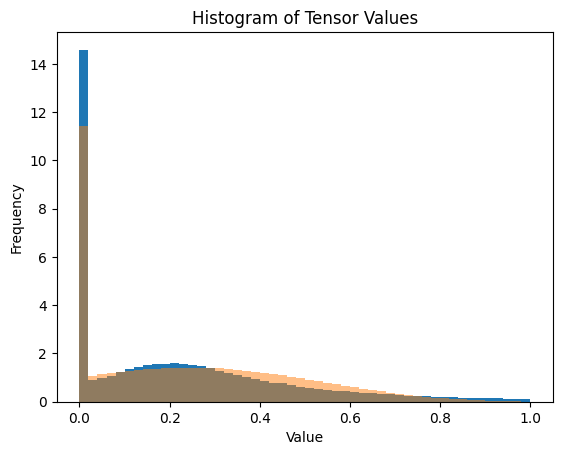

In [34]:
from data_preparation import generate_histogram
generate_histogram(test_predictions.cpu(), hr_train)

In [35]:
from data_preparation import generate_submission_file

df = generate_submission_file(test_predictions.cpu(), 'submission_files/tim_deep1.csv')

# Cross Validation

In [34]:
from evaluation_fn import evaluate_predictions

def validation(up_changer, testloader, val_adj_hr):
    print('begin validation')
    up_changer.eval()

    val_predictions = []
    for X_lr, Y_lr, adj_lr in tqdm(testloader):
        pred = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))[-1].detach()
        val_predictions.append(pred)
        val_predictions = torch.cat(val_predictions)

    return evaluate_predictions(val_predictions, val_adj_hr)

In [45]:
def cross_validate(epochs, batch_size, n_fold, X_lr, Y_lr, adj_lr, X_hr, Y_hr, adj_hr, num_steps, f=32):
    kf = KFold(n_fold, shuffle=True, random_state=99)
    runs_results = []
    for train_idx, val_idx in kf.split(X_lr):
        train_X_lr, val_X_lr = X_lr[train_idx], X_lr[val_idx]
        train_Y_lr, val_Y_lr = Y_lr[train_idx], Y_lr[val_idx]
        train_adj_lr, val_adj_lr = adj_lr[train_idx], adj_lr[val_idx]
        train_X_hr = X_hr[train_idx]
        train_Y_hr = Y_hr[train_idx]
        train_adj_hr, val_adj_hr = adj_hr[train_idx], adj_hr[val_idx]

        trainloader = DataLoader(list(zip(train_X_lr, train_Y_lr, train_adj_lr, train_X_hr, train_Y_hr, train_adj_hr)), shuffle=True, batch_size=batch_size)

        dim_steps = generate_steps(num_steps=10)

        up_changer = AdjacencyDimChanger(dim_steps, f=f).to(DEVICE)
        down_changer = AdjacencyDimChanger(dim_steps[::-1], f=f).to(DEVICE)

        up_optimizer = torch.optim.AdamW(up_changer.parameters(), lr=0.001, betas=(0.5, 0.999))
        down_optimizer = torch.optim.AdamW(down_changer.parameters(), lr=0.001, betas=(0.5, 0.999))    
        
        up_changer, down_changer, _ = train(epochs, up_changer, down_changer, trainloader, up_optimizer, down_optimizer)

        testloader = DataLoader(list(zip(val_X_lr, val_Y_lr, val_adj_lr)), shuffle=True, batch_size=batch_size)
        val_metrics = validation(up_changer, testloader, val_adj_hr)
        runs_results.append(val_metrics)

    return runs_results

In [44]:
cross_validate(10, 32, 3, lr_X_dim1, lr_X_dim3, lr_train, hr_X_dim1, hr_X_dim3, hr_train, num_steps=10)

100%|██████████| 4/4 [00:04<00:00,  1.23s/it]


epoch 0: down loss = 0.16657862812280655, up loss = 0.17240623757243156
Down end adj mae 0.2933386266231537
Up end adj mae 0.3219270035624504


100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


epoch 1: down loss = 0.1626523919403553, up loss = 0.16844239458441734
Down end adj mae 0.2819127216935158
Up end adj mae 0.3124385103583336


100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


epoch 2: down loss = 0.15839369967579842, up loss = 0.16447226703166962
Down end adj mae 0.27673444896936417
Up end adj mae 0.30724405497312546


100%|██████████| 4/4 [00:04<00:00,  1.16s/it]


epoch 3: down loss = 0.15335677191615105, up loss = 0.16132723540067673
Down end adj mae 0.2676369547843933
Up end adj mae 0.2964955344796181


100%|██████████| 4/4 [00:04<00:00,  1.16s/it]


epoch 4: down loss = 0.14681177586317062, up loss = 0.15725039690732956
Down end adj mae 0.2593224421143532
Up end adj mae 0.2961497902870178


100%|██████████| 4/4 [00:04<00:00,  1.14s/it]


epoch 5: down loss = 0.14200948178768158, up loss = 0.15268298611044884
Down end adj mae 0.24048680439591408
Up end adj mae 0.27916480600833893


100%|██████████| 4/4 [00:04<00:00,  1.15s/it]


epoch 6: down loss = 0.1396225169301033, up loss = 0.14996973052620888
Down end adj mae 0.24390818551182747
Up end adj mae 0.27464043349027634


100%|██████████| 4/4 [00:04<00:00,  1.13s/it]


epoch 7: down loss = 0.13328664749860764, up loss = 0.1465534344315529
Down end adj mae 0.2331133522093296
Up end adj mae 0.2700587958097458


100%|██████████| 4/4 [00:04<00:00,  1.13s/it]


epoch 8: down loss = 0.12946145981550217, up loss = 0.14318590611219406
Down end adj mae 0.22815408930182457
Up end adj mae 0.2646156772971153


100%|██████████| 4/4 [00:04<00:00,  1.13s/it]

epoch 9: down loss = 0.12732424959540367, up loss = 0.14039869233965874
Down end adj mae 0.22381966933608055
Up end adj mae 0.260972585529089


ValueError: too many values to unpack (expected 2)